In [2]:
import os

In [3]:
os.chdir('..')

In [4]:
os.listdir()

['longreddit_construction',
 '.DS_Store',
 'factorization',
 '__init__.py',
 'factorization_long',
 '__pycache__',
 'utils.py',
 'data',
 'data_long']

In [5]:
import utils

In [6]:
import pickle

In [7]:
with open('data_long/rank_to_factors.p', 'rb') as f:
    rank_to_factors = pickle.load(f)

In [8]:
rank_to_factors[9][0].shape # comment step (ordered)

(18, 9)

In [9]:
rank_to_factors[9][1].shape # threads (unordered)

(29487, 9)

In [10]:
rank_to_factors[9][2].shape # hypergraph_feats (unordered)

(164, 9)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Comment step", "Threads", "Features"] if d==3 else ["Time", "Features"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()

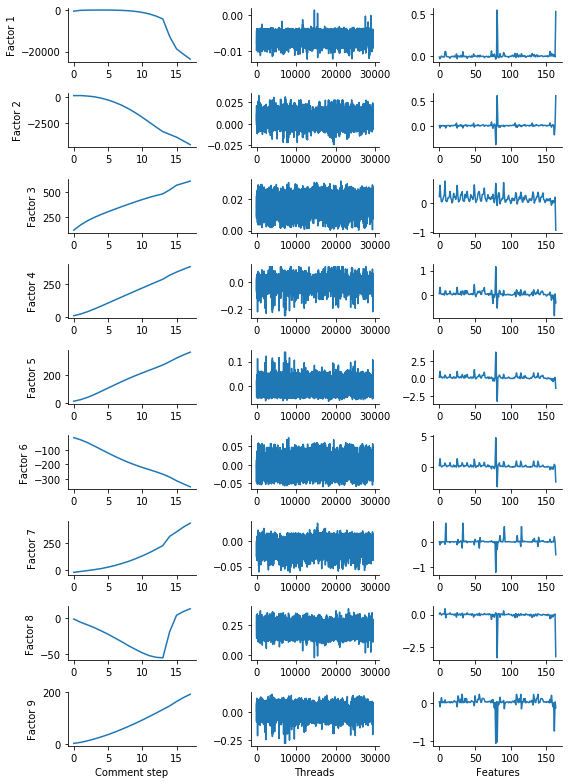

In [13]:
plot_factors(rank_to_factors[9])

## Interpreting the factors

In [14]:
time_factor = rank_to_factors[9][0] # (9, 9)
thread_factor = rank_to_factors[9][1] # (10000, 9)
feature_factor = rank_to_factors[9][2] # (164, 9)

In [15]:
feature_factor.shape

(164, 9)

In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

In [17]:
with open('data_long/hg_features.p', 'rb') as f:
    hg_features = pickle.load(f)

In [18]:
with open('data_long/subreddits.p', 'rb') as f:
    subreddits = pickle.load(f)

In [19]:
def get_anomalous_points(factor_full, idx):
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > 1.5).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -1.5).flatten()
    return pos_pts, neg_pts

In [20]:
pos_pts, neg_pts = get_anomalous_points(feature_factor, 0)

In [21]:
for pt in neg_pts:
    print(hg_features[pt])

In [22]:
from collections import defaultdict, Counter

In [23]:
idx_to_distinctive_threads = defaultdict(dict)
idx_to_distinctive_features = defaultdict(dict)

In [24]:
subreddit_totals = Counter(subreddits)

In [25]:
for idx in range(9):
    pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
    idx_to_distinctive_threads[idx]['pos_threads'] = Counter([subreddits[i] for i in pos_thread_pts])
    idx_to_distinctive_threads[idx]['neg_threads'] = Counter([subreddits[i] for i in neg_thread_pts])
    
    # normalize subreddit counts
    for subreddit in idx_to_distinctive_threads[idx]['pos_threads']:
        idx_to_distinctive_threads[idx]['pos_threads'][subreddit] /= subreddit_totals[subreddit]
        idx_to_distinctive_threads[idx]['neg_threads'][subreddit] /= subreddit_totals[subreddit]
    
    pos_features, neg_features = get_anomalous_points(feature_factor, idx)
    idx_to_distinctive_features[idx]['pos_features'] = [hg_features[i] for i in pos_features]
    idx_to_distinctive_features[idx]['neg_features'] = [hg_features[i] for i in neg_features]

In [29]:
get_anomalous_points(thread_factor, 0)[1]

array([    2,     7,     9, ..., 29425, 29430, 29456])

In [26]:
idx_to_distinctive_threads[0]

{'pos_threads': Counter({'MaliciousCompliance': 0.04292929292929293,
          'techsupport': 0.01639344262295082,
          'cringepics': 0.0440771349862259,
          'lgbt': 0.014084507042253521,
          'Minecraft': 0.03723404255319149,
          'NoFap': 0.08108108108108109,
          'conspiracy': 0.03289473684210526,
          'guns': 0.035555555555555556,
          'Frugal': 0.08178438661710037,
          'wow': 0.04516129032258064,
          'Android': 0.04709141274238227,
          'Games': 0.04645476772616137,
          'pokemon': 0.037383177570093455,
          'Drugs': 0.035897435897435895,
          'CFB': 0.03900709219858156,
          'IAmA': 0.0267639902676399,
          'MensRights': 0.030303030303030304,
          'magicTCG': 0.02875399361022364,
          'business': 0.02476780185758514,
          'WTF': 0.041666666666666664,
          'askscience': 0.0449438202247191,
          'leagueoflegends': 0.03155339805825243,
          'Diablo': 0.018018018018018018,
    

In [30]:
for idx in range(9):
    print("### FACTOR {} ###".format(idx+1))
    
    pos_subreddits = sorted(list(idx_to_distinctive_threads[idx]['pos_threads'].items()), key=lambda x: x[1], reverse=True)
    neg_subreddits = sorted(list(idx_to_distinctive_threads[idx]['neg_threads'].items()), key=lambda x: x[1], reverse=True)

    print()
    print("Positive subreddits: {}".format([k for k, v in pos_subreddits[:5]]))
    print()
    print("Negative subreddits: {}".format([k for k, v in neg_subreddits[:5]]))
    print()
    print("Positive features: {}".format(idx_to_distinctive_features[idx]['pos_features'][:10]))
    print()
    print("Negative features: {}".format(idx_to_distinctive_features[idx]['neg_features'][:10]))
    
    print("#########################################\n\n")

### FACTOR 1 ###

Positive subreddits: ['Frugal', 'SquaredCircle', 'NoFap', 'movies', 'books']

Negative subreddits: ['AskTrumpSupporters', 'Random_Acts_Of_Amazon', 'singapore', 'MakeupAddiction', 'relationships']

Positive features: ['count[outgoing triads]', 'count[outgoing triads over mid-thread]']

Negative features: []
#########################################


### FACTOR 2 ###

Positive subreddits: ['relationships', 'IAmA', 'aww', 'politics', 'SquaredCircle']

Negative subreddits: ['POLITIC', 'pokemontrades', 'electronic_cigarette', 'Christianity', 'CanadaPolitics']

Positive features: ['count[outgoing triads]', 'count[outgoing triads over mid-thread]']

Negative features: ['count[incoming triads]', 'count[incoming triads over mid-thread]']
#########################################


### FACTOR 3 ###

Positive subreddits: ['pokemontrades', 'techsupport', 'POLITIC', 'buildapc', 'teenagers']

Negative subreddits: ['Random_Acts_Of_Amazon', 'ShingekiNoKyojin', 'AskWomen', 'books', '